In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn.utils as utils

# Importing Data

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
X_valid = X_train[:10000,...]
y_valid = y_train[:10000]

X_train = X_train[10000:,...]
y_train = y_train[10000:]

In [5]:
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_valid_tensor = torch.from_numpy(X_valid)
y_valid_tensor = torch.from_numpy(y_valid)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

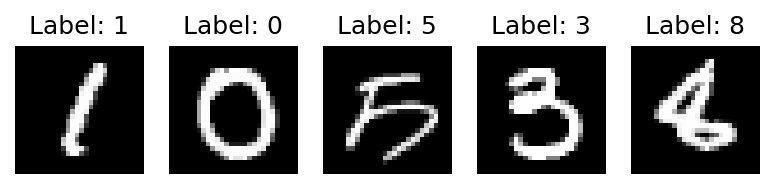

In [6]:
num_images_to_show = 5
random_indices = np.random.randint(0, len(X_train), num_images_to_show)
plt.figure(dpi=150)

# Plotting the images
for i, idx in enumerate(random_indices, 1):
    plt.subplot(1, num_images_to_show, i)
    plt.imshow(X_train[idx].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')

plt.show()

In [7]:
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss'])
results

,Model,Accuracy,Loss


# Standard Neural Net 

In [8]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
net = nn.Sequential(
    OrderedDict([
        ('flatten', nn.Flatten()),
        ('linear1', nn.Linear(784, 800)),
        ('logistic1', nn.Sigmoid()),       
        ('linear2', nn.Linear(800, 800)),  
        ('logistic2', nn.Sigmoid()),       
        ('linear3', nn.Linear(800, 10)), 
    ])
)

print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.5)

train_loss_list1 = list()
train_acc_list1 = list()
valid_loss_list1 = list()
valid_acc_list1 = list()

Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=800, bias=True)
  (logistic1): Sigmoid()
  (linear2): Linear(in_features=800, out_features=800, bias=True)
  (logistic2): Sigmoid()
  (linear3): Linear(in_features=800, out_features=10, bias=True)
)


In [10]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_per_process_memory_fraction(0.8, device=device.index)
net.to(device)

Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=800, bias=True)
  (logistic1): Sigmoid()
  (linear2): Linear(in_features=800, out_features=800, bias=True)
  (logistic2): Sigmoid()
  (linear3): Linear(in_features=800, out_features=10, bias=True)
)

In [11]:
num_epochs = 1000
seed = 42
torch.manual_seed(seed)

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validation Loop
    net.eval()
    running_loss_valid = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs_valid, labels_valid in valid_loader:
            inputs_valid = inputs_valid.float()
            inputs_valid, labels_valid = inputs_valid.to(device), labels_valid.to(device)
            outputs_valid = net(inputs_valid)
            loss_valid = criterion(outputs_valid, labels_valid)
            running_loss_valid += loss_valid.item()

            _, predicted_valid = torch.max(outputs_valid.data, 1)
            total_valid += labels_valid.size(0)
            correct_valid += (predicted_valid == labels_valid).sum().item()

    valid_accuracy = correct_valid / total_valid
    valid_loss = running_loss_valid / len(valid_loader)

    train_loss_list1.append(train_loss)
    train_acc_list1.append(train_accuracy)
    valid_loss_list1.append(valid_loss)
    valid_acc_list1.append(valid_accuracy)
    
    if epoch%100==0:
        print(f'Epoch {epoch + 1}/{num_epochs}, ' +
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, ' +
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

print('Finished Training')

Epoch 1/1200, Train Loss: 0.6331, Train Acc: 0.8125, Valid Loss: 0.4405, Valid Acc: 0.8747
Epoch 101/1200, Train Loss: 0.1881, Train Acc: 0.9398, Valid Loss: 0.2413, Valid Acc: 0.9207
Epoch 201/1200, Train Loss: 0.1539, Train Acc: 0.9513, Valid Loss: 0.1873, Valid Acc: 0.9399
Epoch 301/1200, Train Loss: 0.1507, Train Acc: 0.9497, Valid Loss: 0.2012, Valid Acc: 0.9382
Epoch 401/1200, Train Loss: 0.1279, Train Acc: 0.9587, Valid Loss: 0.1603, Valid Acc: 0.9501
Epoch 501/1200, Train Loss: 0.1358, Train Acc: 0.9552, Valid Loss: 0.1718, Valid Acc: 0.9481
Epoch 601/1200, Train Loss: 0.1172, Train Acc: 0.9606, Valid Loss: 0.1560, Valid Acc: 0.9502
Epoch 701/1200, Train Loss: 0.1085, Train Acc: 0.9643, Valid Loss: 0.1504, Valid Acc: 0.9515
Epoch 801/1200, Train Loss: 0.0968, Train Acc: 0.9675, Valid Loss: 0.1447, Valid Acc: 0.9569
Epoch 901/1200, Train Loss: 0.1204, Train Acc: 0.9593, Valid Loss: 0.1539, Valid Acc: 0.9541
Epoch 1001/1200, Train Loss: 0.1082, Train Acc: 0.9634, Valid Loss: 0.16

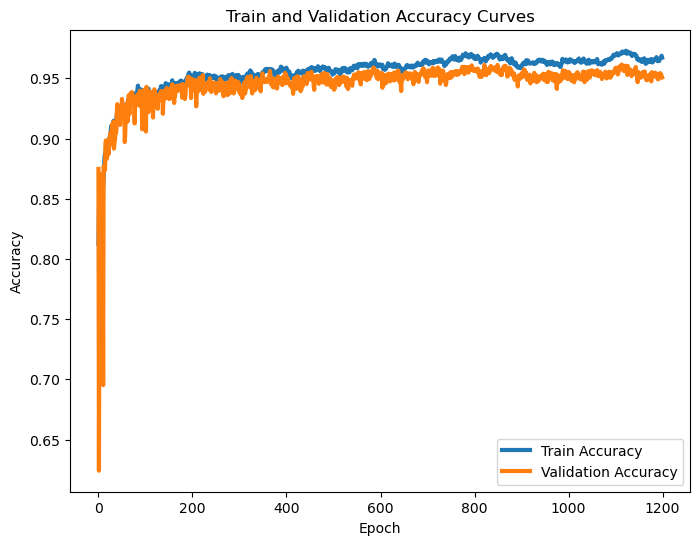

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(train_acc_list1, label='Train Accuracy', lw=3)
plt.plot(valid_acc_list1, label='Validation Accuracy', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Curves')
plt.legend()
plt.show()

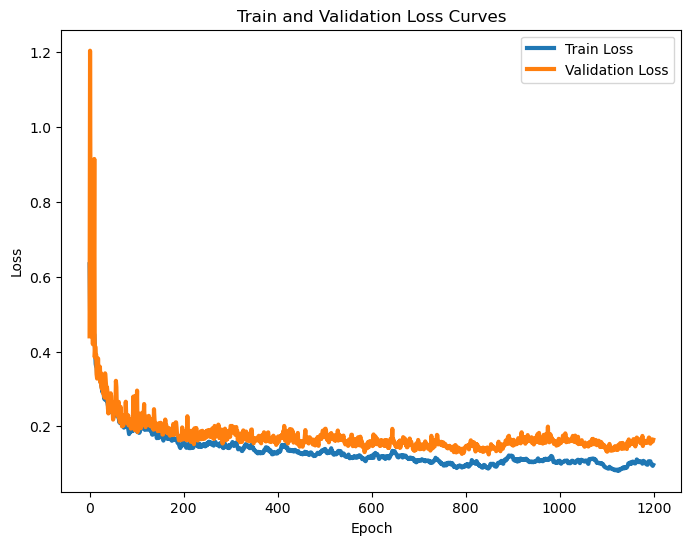

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss_list1, label='Train Loss', lw=3)
plt.plot(valid_loss_list1, label='Validation Loss', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.show()

In [14]:
net.eval()
running_loss_test = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs_test, labels_test in test_loader:
        inputs_test = inputs_test.float()
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs_test = net(inputs_test)
        loss_test = criterion(outputs_test, labels_test)
        running_loss_test += loss_test.item()

        _, predicted_test = torch.max(outputs_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

test_accuracy = correct_test / total_test
test_loss = running_loss_test / len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')



Test Loss: 0.1649, Test Acc: 0.9496


In [15]:
results_temp = pd.DataFrame(
    [[
        'Standard NN',
        test_accuracy,
        test_loss
    ]],
    columns=['Model', 'Accuracy', 'Loss']
)

results = pd.concat([results, results_temp], ignore_index=True)
results

,Model,Accuracy,Loss
0,Standard NN,0.9496,0.164916


# Dropout NN (Logistic)

In [16]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [17]:
net = nn.Sequential(
    OrderedDict([
        ('dropout1', nn.Dropout(0.2)),
        ('flatten', nn.Flatten()),
        ('linear1', nn.Linear(784, 1024)),
        ('logistic1', nn.Sigmoid()),
        ('dropout2', nn.Dropout(0.5)),  
        ('linear2', nn.Linear(1024, 1024)),  
        ('logistic2', nn.Sigmoid()),
        ('dropout3', nn.Dropout(0.5)),
        ('linear3', nn.Linear(1024, 1024)),  
        ('logistic3', nn.Sigmoid()),
        ('dropout4', nn.Dropout(0.5)), 
        ('linear4', nn.Linear(1024, 10)),  
    ])
)

print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.5)

train_loss_list2 = list()
train_acc_list2 = list()
valid_loss_list2 = list()
valid_acc_list2 = list()

Sequential(
  (dropout1): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (logistic1): Sigmoid()
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (logistic2): Sigmoid()
  (dropout3): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=1024, out_features=1024, bias=True)
  (logistic3): Sigmoid()
  (dropout4): Dropout(p=0.5, inplace=False)
  (linear4): Linear(in_features=1024, out_features=10, bias=True)
)


In [18]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_per_process_memory_fraction(0.8, device=device.index)
net.to(device)

Sequential(
  (dropout1): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (logistic1): Sigmoid()
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (logistic2): Sigmoid()
  (dropout3): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=1024, out_features=1024, bias=True)
  (logistic3): Sigmoid()
  (dropout4): Dropout(p=0.5, inplace=False)
  (linear4): Linear(in_features=1024, out_features=10, bias=True)
)

In [19]:
num_epochs = 1000
seed = 42
torch.manual_seed(seed)

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validation Loop
    net.eval()
    running_loss_valid = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs_valid, labels_valid in valid_loader:
            inputs_valid = inputs_valid.float()
            inputs_valid, labels_valid = inputs_valid.to(device), labels_valid.to(device)
            outputs_valid = net(inputs_valid)
            loss_valid = criterion(outputs_valid, labels_valid)
            running_loss_valid += loss_valid.item()

            _, predicted_valid = torch.max(outputs_valid.data, 1)
            total_valid += labels_valid.size(0)
            correct_valid += (predicted_valid == labels_valid).sum().item()

    valid_accuracy = correct_valid / total_valid
    valid_loss = running_loss_valid / len(valid_loader)

    train_loss_list2.append(train_loss)
    train_acc_list2.append(train_accuracy)
    valid_loss_list2.append(valid_loss)
    valid_acc_list2.append(valid_accuracy)
    
    if epoch%100==0:
        print(f'Epoch {epoch + 1}/{num_epochs}, ' +
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, ' +
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

print('Finished Training')

Epoch 1/1200, Train Loss: 1.4512, Train Acc: 0.4774, Valid Loss: 0.7712, Valid Acc: 0.7217
Epoch 101/1200, Train Loss: 0.2572, Train Acc: 0.9165, Valid Loss: 0.1316, Valid Acc: 0.9582
Epoch 201/1200, Train Loss: 0.1908, Train Acc: 0.9374, Valid Loss: 0.0967, Valid Acc: 0.9707
Epoch 301/1200, Train Loss: 0.1569, Train Acc: 0.9487, Valid Loss: 0.0806, Valid Acc: 0.9757
Epoch 401/1200, Train Loss: 0.1377, Train Acc: 0.9537, Valid Loss: 0.0742, Valid Acc: 0.9779
Epoch 501/1200, Train Loss: 0.1321, Train Acc: 0.9565, Valid Loss: 0.0678, Valid Acc: 0.9799
Epoch 601/1200, Train Loss: 0.1204, Train Acc: 0.9602, Valid Loss: 0.0686, Valid Acc: 0.9802
Epoch 701/1200, Train Loss: 0.1098, Train Acc: 0.9627, Valid Loss: 0.0656, Valid Acc: 0.9819
Epoch 801/1200, Train Loss: 0.1017, Train Acc: 0.9661, Valid Loss: 0.0624, Valid Acc: 0.9826
Epoch 901/1200, Train Loss: 0.1011, Train Acc: 0.9666, Valid Loss: 0.0631, Valid Acc: 0.9822
Epoch 1001/1200, Train Loss: 0.0970, Train Acc: 0.9680, Valid Loss: 0.06

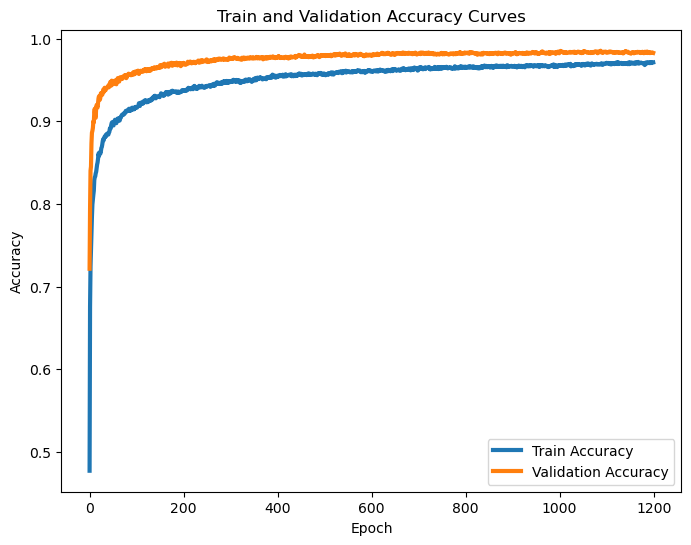

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(train_acc_list2, label='Train Accuracy', lw=3)
plt.plot(valid_acc_list2, label='Validation Accuracy', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Curves')
plt.legend()
plt.show()

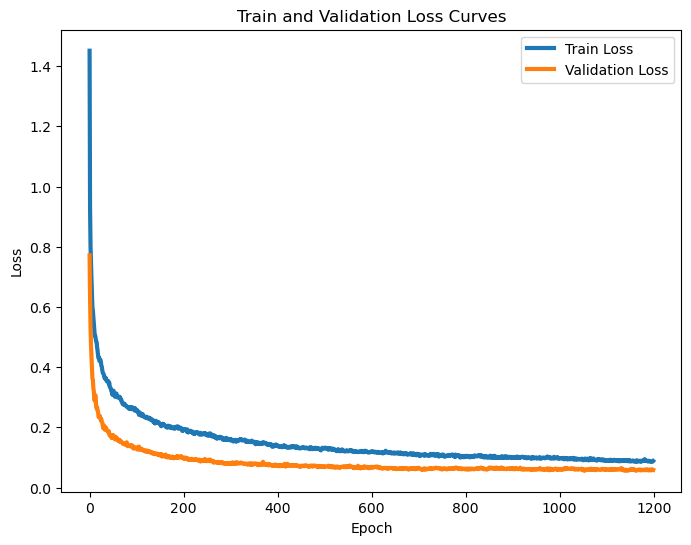

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss_list2, label='Train Loss', lw=3)
plt.plot(valid_loss_list2, label='Validation Loss', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.show()

In [22]:
net.eval()
running_loss_test = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs_test, labels_test in test_loader:
        inputs_test = inputs_test.float()
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs_test = net(inputs_test)
        loss_test = criterion(outputs_test, labels_test)
        running_loss_test += loss_test.item()

        _, predicted_test = torch.max(outputs_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

test_accuracy = correct_test / total_test
test_loss = running_loss_test / len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')



Test Loss: 0.0548, Test Acc: 0.9833


In [23]:
results_temp = pd.DataFrame(
    [[
        'Dropout NN (Logistic)',
        test_accuracy,
        test_loss
    ]],
    columns=['Model', 'Accuracy', 'Loss']
)

results = pd.concat([results, results_temp], ignore_index=True)
results

,Model,Accuracy,Loss
0,Standard NN,0.9496,0.164916
1,Dropout NN (Logistic),0.9833,0.054762


# Dropout NN (ReLu)

In [24]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [25]:
net = nn.Sequential(
    OrderedDict([
        ('dropout1', nn.Dropout(0.2)),
        ('flatten', nn.Flatten()),
        ('linear1', nn.Linear(784, 1024)),
        ('relu1', nn.ReLU()),
        ('dropout2', nn.Dropout(0.5)),  
        ('linear2', nn.Linear(1024, 1024)),  
        ('relu2', nn.ReLU()),
        ('dropout3', nn.Dropout(0.5)),
        ('linear3', nn.Linear(1024, 1024)),  
        ('relu3', nn.ReLU()),
        ('dropout4', nn.Dropout(0.5)), 
        ('linear4', nn.Linear(1024, 10)),  
    ])
)

print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.5)

train_loss_list3 = list()
train_acc_list3 = list()
valid_loss_list3 = list()
valid_acc_list3 = list()

Sequential(
  (dropout1): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=1024, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout4): Dropout(p=0.5, inplace=False)
  (linear4): Linear(in_features=1024, out_features=10, bias=True)
)


In [26]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_per_process_memory_fraction(0.8, device=device.index)
net.to(device)

Sequential(
  (dropout1): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=1024, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout4): Dropout(p=0.5, inplace=False)
  (linear4): Linear(in_features=1024, out_features=10, bias=True)
)

In [27]:
num_epochs = 1000
seed = 42
torch.manual_seed(seed)

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validation Loop
    net.eval()
    running_loss_valid = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs_valid, labels_valid in valid_loader:
            inputs_valid = inputs_valid.float()
            inputs_valid, labels_valid = inputs_valid.to(device), labels_valid.to(device)
            outputs_valid = net(inputs_valid)
            loss_valid = criterion(outputs_valid, labels_valid)
            running_loss_valid += loss_valid.item()

            _, predicted_valid = torch.max(outputs_valid.data, 1)
            total_valid += labels_valid.size(0)
            correct_valid += (predicted_valid == labels_valid).sum().item()

    valid_accuracy = correct_valid / total_valid
    valid_loss = running_loss_valid / len(valid_loader)

    train_loss_list3.append(train_loss)
    train_acc_list3.append(train_accuracy)
    valid_loss_list3.append(valid_loss)
    valid_acc_list3.append(valid_accuracy)
    
    if epoch%100==0:
        print(f'Epoch {epoch + 1}/{num_epochs}, ' +
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, ' +
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

print('Finished Training')

Epoch 1/1200, Train Loss: nan, Train Acc: 0.0982, Valid Loss: nan, Valid Acc: 0.1001
Epoch 101/1200, Train Loss: nan, Train Acc: 0.0984, Valid Loss: nan, Valid Acc: 0.1001
Epoch 201/1200, Train Loss: nan, Train Acc: 0.0984, Valid Loss: nan, Valid Acc: 0.1001
Epoch 301/1200, Train Loss: nan, Train Acc: 0.0984, Valid Loss: nan, Valid Acc: 0.1001
Epoch 401/1200, Train Loss: nan, Train Acc: 0.0984, Valid Loss: nan, Valid Acc: 0.1001
Epoch 501/1200, Train Loss: nan, Train Acc: 0.0984, Valid Loss: nan, Valid Acc: 0.1001
Epoch 601/1200, Train Loss: nan, Train Acc: 0.0984, Valid Loss: nan, Valid Acc: 0.1001
Epoch 701/1200, Train Loss: nan, Train Acc: 0.0984, Valid Loss: nan, Valid Acc: 0.1001
Epoch 801/1200, Train Loss: nan, Train Acc: 0.0984, Valid Loss: nan, Valid Acc: 0.1001
Epoch 901/1200, Train Loss: nan, Train Acc: 0.0984, Valid Loss: nan, Valid Acc: 0.1001
Epoch 1001/1200, Train Loss: nan, Train Acc: 0.0984, Valid Loss: nan, Valid Acc: 0.1001
Epoch 1101/1200, Train Loss: nan, Train Acc:

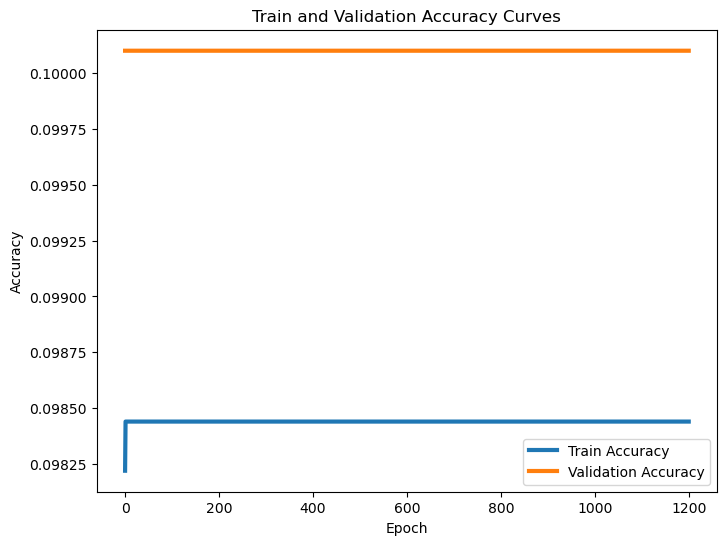

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(train_acc_list3, label='Train Accuracy', lw=3)
plt.plot(valid_acc_list3, label='Validation Accuracy', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Curves')
plt.legend()
plt.show()

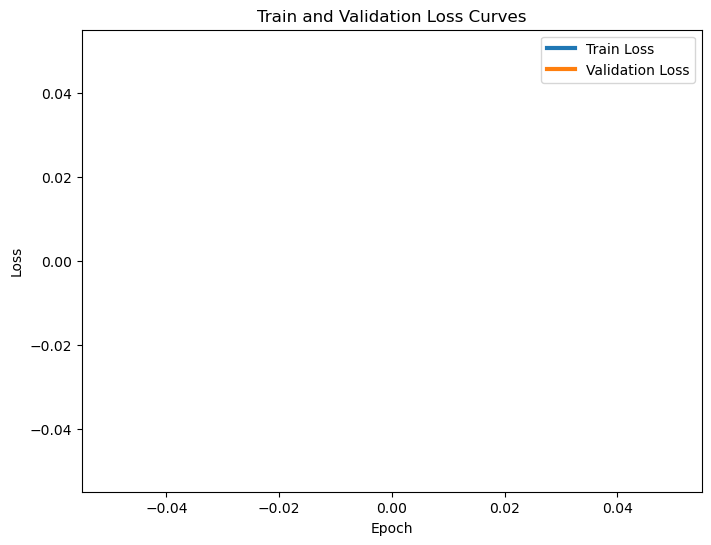

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss_list3, label='Train Loss', lw=3)
plt.plot(valid_loss_list3, label='Validation Loss', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.show()

In [30]:
net.eval()
running_loss_test = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs_test, labels_test in test_loader:
        inputs_test = inputs_test.float()
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs_test = net(inputs_test)
        loss_test = criterion(outputs_test, labels_test)
        running_loss_test += loss_test.item()

        _, predicted_test = torch.max(outputs_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

test_accuracy = correct_test / total_test
test_loss = running_loss_test / len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')



Test Loss: nan, Test Acc: 0.0980


In [31]:
results_temp = pd.DataFrame(
    [[
        'Dropout NN (ReLu)',
        test_accuracy,
        test_loss
    ]],
    columns=['Model', 'Accuracy', 'Loss']
)

results = pd.concat([results, results_temp], ignore_index=True)
results

,Model,Accuracy,Loss
0,Standard NN,0.9496,0.164916
1,Dropout NN (Logistic),0.9833,0.054762
2,Dropout NN (ReLu),0.0980,NaN


# Dropout NN + Max Norm (ReLu, 1024)

In [32]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [33]:
net = nn.Sequential(
    OrderedDict([
        ('dropout1', nn.Dropout(0.2)),
        ('flatten', nn.Flatten()),
        ('linear1', nn.Linear(784, 1024)),
        ('relu1', nn.ReLU()),
        ('dropout2', nn.Dropout(0.5)),  
        ('linear2', nn.Linear(1024, 1024)),  
        ('relu2', nn.ReLU()),
        ('dropout3', nn.Dropout(0.5)),
        ('linear3', nn.Linear(1024, 1024)),  
        ('relu3', nn.ReLU()),
        ('dropout4', nn.Dropout(0.5)), 
        ('linear4', nn.Linear(1024, 10)),  
    ])
)

print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.5)


train_loss_list4 = list()
train_acc_list4 = list()
valid_loss_list4 = list()
valid_acc_list4 = list()

Sequential(
  (dropout1): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=1024, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout4): Dropout(p=0.5, inplace=False)
  (linear4): Linear(in_features=1024, out_features=10, bias=True)
)


In [34]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_per_process_memory_fraction(0.8, device=device.index)
net.to(device)

Sequential(
  (dropout1): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=1024, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout4): Dropout(p=0.5, inplace=False)
  (linear4): Linear(in_features=1024, out_features=10, bias=True)
)

In [35]:
num_epochs = 1000
seed = 42
torch.manual_seed(seed)

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply max norm constraint to the gradients
        max_norm = 1.0  # Set your desired max norm value
        for name, param in net.named_parameters():
            if 'weight' in name:
                utils.clip_grad_norm_(param, max_norm)

        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)
    
    # Validation Loop
    net.eval()
    running_loss_valid = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs_valid, labels_valid in valid_loader:
            inputs_valid = inputs_valid.float()
            inputs_valid, labels_valid = inputs_valid.to(device), labels_valid.to(device)
            outputs_valid = net(inputs_valid)
            loss_valid = criterion(outputs_valid, labels_valid)
            running_loss_valid += loss_valid.item()

            _, predicted_valid = torch.max(outputs_valid.data, 1)
            total_valid += labels_valid.size(0)
            correct_valid += (predicted_valid == labels_valid).sum().item()

    valid_accuracy = correct_valid / total_valid
    valid_loss = running_loss_valid / len(valid_loader)

    train_loss_list4.append(train_loss)
    train_acc_list4.append(train_accuracy)
    valid_loss_list4.append(valid_loss)
    valid_acc_list4.append(valid_accuracy)
    
    if epoch%100==0:
        print(f'Epoch {epoch + 1}/{num_epochs}, ' +
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, ' +
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

print('Finished Training')

Epoch 1/1200, Train Loss: 1.1566, Train Acc: 0.7304, Valid Loss: 0.3305, Valid Acc: 0.9169
Epoch 101/1200, Train Loss: 0.8500, Train Acc: 0.8571, Valid Loss: 0.5055, Valid Acc: 0.9285
Epoch 201/1200, Train Loss: 1.0386, Train Acc: 0.8280, Valid Loss: 0.6261, Valid Acc: 0.8992
Epoch 301/1200, Train Loss: 1.1233, Train Acc: 0.8122, Valid Loss: 0.6577, Valid Acc: 0.9034
Epoch 401/1200, Train Loss: 0.9956, Train Acc: 0.8170, Valid Loss: 0.7787, Valid Acc: 0.8947
Epoch 501/1200, Train Loss: 1.0531, Train Acc: 0.7898, Valid Loss: 0.8905, Valid Acc: 0.8618
Epoch 601/1200, Train Loss: 1.0131, Train Acc: 0.8109, Valid Loss: 0.8248, Valid Acc: 0.8687
Epoch 701/1200, Train Loss: 0.9693, Train Acc: 0.7991, Valid Loss: 0.6794, Valid Acc: 0.8846
Epoch 801/1200, Train Loss: 0.9978, Train Acc: 0.7947, Valid Loss: 0.7560, Valid Acc: 0.8511
Epoch 901/1200, Train Loss: 1.0279, Train Acc: 0.7880, Valid Loss: 0.7388, Valid Acc: 0.8407
Epoch 1001/1200, Train Loss: 0.9465, Train Acc: 0.7745, Valid Loss: 0.75

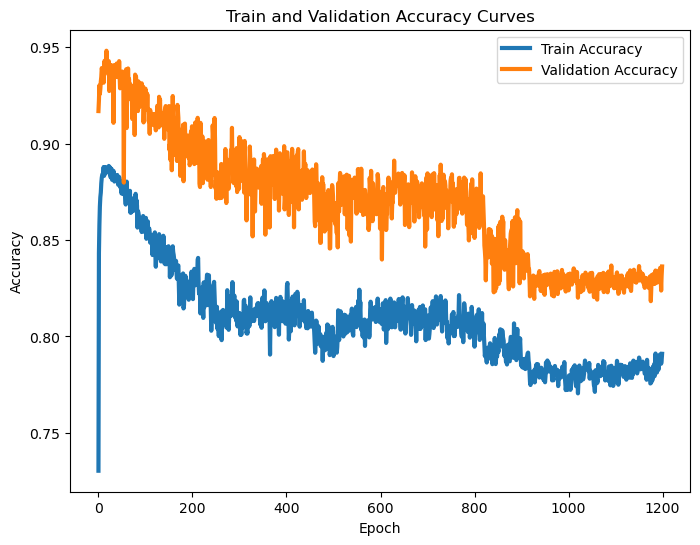

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(train_acc_list4, label='Train Accuracy', lw=3)
plt.plot(valid_acc_list4, label='Validation Accuracy', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Curves')
plt.legend()
plt.show()

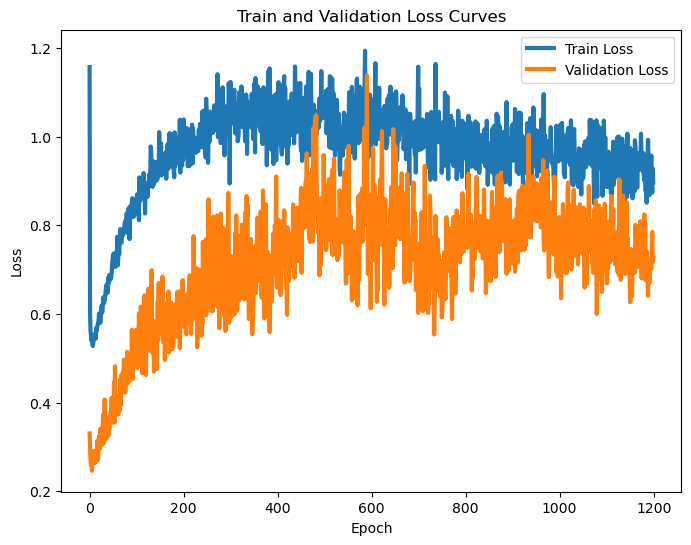

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss_list4, label='Train Loss', lw=3)
plt.plot(valid_loss_list4, label='Validation Loss', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.show()

In [38]:
net.eval()
running_loss_test = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs_test, labels_test in test_loader:
        inputs_test = inputs_test.float()
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs_test = net(inputs_test)
        loss_test = criterion(outputs_test, labels_test)
        running_loss_test += loss_test.item()

        _, predicted_test = torch.max(outputs_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

test_accuracy = correct_test / total_test
test_loss = running_loss_test / len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')



Test Loss: 0.8046, Test Acc: 0.8370


In [39]:
results_temp = pd.DataFrame(
    [[
        'Dropout NN + Max (ReLu, 1024)',
        test_accuracy,
        test_loss
    ]],
    columns=['Model', 'Accuracy', 'Loss']
)

results = pd.concat([results, results_temp], ignore_index=True)
results

,Model,Accuracy,Loss
0,Standard NN,0.9496,0.164916
1,Dropout NN (Logistic),0.9833,0.054762
2,Dropout NN (ReLu),0.0980,NaN
3,"Dropout NN + Max (ReLu, 1024)",0.8370,0.804606


# Dropout NN + Max Norm (ReLu, 2048) 

In [40]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [41]:
net = nn.Sequential(
    OrderedDict([
        ('dropout1', nn.Dropout(0.2)),
        ('flatten', nn.Flatten()),
        ('linear1', nn.Linear(784, 2048)),
        ('relu1', nn.ReLU()),
        ('dropout2', nn.Dropout(0.5)),  
        ('linear2', nn.Linear(2048, 2048)),  
        ('relu2', nn.ReLU()),
        ('dropout3', nn.Dropout(0.5)),
        ('linear3', nn.Linear(2048, 2048)),  
        ('relu3', nn.ReLU()),
        ('dropout4', nn.Dropout(0.5)), 
        ('linear4', nn.Linear(2048, 10)),  
    ])
)

print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.5)

train_loss_list5 = list()
train_acc_list5 = list()
valid_loss_list5 = list()
valid_acc_list5 = list()

Sequential(
  (dropout1): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=2048, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=2048, out_features=2048, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=2048, out_features=2048, bias=True)
  (relu3): ReLU()
  (dropout4): Dropout(p=0.5, inplace=False)
  (linear4): Linear(in_features=2048, out_features=10, bias=True)
)


In [42]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_per_process_memory_fraction(0.8, device=device.index)
net.to(device)

Sequential(
  (dropout1): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=2048, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=2048, out_features=2048, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=2048, out_features=2048, bias=True)
  (relu3): ReLU()
  (dropout4): Dropout(p=0.5, inplace=False)
  (linear4): Linear(in_features=2048, out_features=10, bias=True)
)

In [43]:
num_epochs = 1000
seed = 42
torch.manual_seed(seed)

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply max norm constraint to the gradients
        max_norm = 1.0  # Set your desired max norm value
        for name, param in net.named_parameters():
            if 'weight' in name:
                utils.clip_grad_norm_(param, max_norm)

        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)
    
    # Validation Loop
    net.eval()
    running_loss_valid = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs_valid, labels_valid in valid_loader:
            inputs_valid = inputs_valid.float()
            inputs_valid, labels_valid = inputs_valid.to(device), labels_valid.to(device)
            outputs_valid = net(inputs_valid)
            loss_valid = criterion(outputs_valid, labels_valid)
            running_loss_valid += loss_valid.item()

            _, predicted_valid = torch.max(outputs_valid.data, 1)
            total_valid += labels_valid.size(0)
            correct_valid += (predicted_valid == labels_valid).sum().item()

    valid_accuracy = correct_valid / total_valid
    valid_loss = running_loss_valid / len(valid_loader)

    train_loss_list5.append(train_loss)
    train_acc_list5.append(train_accuracy)
    valid_loss_list5.append(valid_loss)
    valid_acc_list5.append(valid_accuracy)
    
    if epoch%100==0:
        print(f'Epoch {epoch + 1}/{num_epochs}, ' +
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, ' +
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

print('Finished Training')

Epoch 1/1200, Train Loss: 1.3202, Train Acc: 0.7474, Valid Loss: 0.3179, Valid Acc: 0.9159


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_acc_list5, label='Train Accuracy', lw=3)
plt.plot(valid_acc_list5, label='Validation Accuracy', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Curves')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss_list5, label='Train Loss', lw=3)
plt.plot(valid_loss_list5, label='Validation Loss', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.show()

In [ ]:
net.eval()
running_loss_test = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs_test, labels_test in test_loader:
        inputs_test = inputs_test.float()
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs_test = net(inputs_test)
        loss_test = criterion(outputs_test, labels_test)
        running_loss_test += loss_test.item()

        _, predicted_test = torch.max(outputs_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

test_accuracy = correct_test / total_test
test_loss = running_loss_test / len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')



In [ ]:
results_temp = pd.DataFrame(
    [[
        'Dropout NN + Max (ReLu, 2048)',
        test_accuracy,
        test_loss
    ]],
    columns=['Model', 'Accuracy', 'Loss']
)

results = pd.concat([results, results_temp], ignore_index=True)
results

# Dropout NN + Max Norm (ReLu, 4096) 

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
net = nn.Sequential(
    OrderedDict([
        ('dropout1', nn.Dropout(0.2)),
        ('flatten', nn.Flatten()),
        ('linear1', nn.Linear(784, 4096)),
        ('relu1', nn.ReLU()),
        ('dropout2', nn.Dropout(0.5)),  
        ('linear2', nn.Linear(4096, 4096)),  
        ('relu2', nn.ReLU()),
        ('dropout3', nn.Dropout(0.5)),
        ('linear3', nn.Linear(4096, 4096)),  
        ('relu3', nn.ReLU()),
        ('dropout4', nn.Dropout(0.5)), 
        ('linear4', nn.Linear(4096, 10)),  
    ])
)

print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.5)

train_loss_list6 = list()
train_acc_list6 = list()
valid_loss_list6 = list()
valid_acc_list6 = list()

In [ ]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_per_process_memory_fraction(0.8, device=device.index)
net.to(device)

In [ ]:
num_epochs = 1000
seed = 42
torch.manual_seed(seed)

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply max norm constraint to the gradients
        max_norm = 1.0  # Set your desired max norm value
        for name, param in net.named_parameters():
            if 'weight' in name:
                utils.clip_grad_norm_(param, max_norm)

        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)
    
    # Validation Loop
    net.eval()
    running_loss_valid = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs_valid, labels_valid in valid_loader:
            inputs_valid = inputs_valid.float()
            inputs_valid, labels_valid = inputs_valid.to(device), labels_valid.to(device)
            outputs_valid = net(inputs_valid)
            loss_valid = criterion(outputs_valid, labels_valid)
            running_loss_valid += loss_valid.item()

            _, predicted_valid = torch.max(outputs_valid.data, 1)
            total_valid += labels_valid.size(0)
            correct_valid += (predicted_valid == labels_valid).sum().item()

    valid_accuracy = correct_valid / total_valid
    valid_loss = running_loss_valid / len(valid_loader)

    train_loss_list6.append(train_loss)
    train_acc_list6.append(train_accuracy)
    valid_loss_list6.append(valid_loss)
    valid_acc_list6.append(valid_accuracy)
    
    if epoch%100==0:
        print(f'Epoch {epoch + 1}/{num_epochs}, ' +
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, ' +
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

print('Finished Training')

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_acc_list6, label='Train Accuracy', lw=3)
plt.plot(valid_acc_list6, label='Validation Accuracy', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Curves')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss_list6, label='Train Loss', lw=3)
plt.plot(valid_loss_list6, label='Validation Loss', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.show()

In [ ]:
net.eval()
running_loss_test = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs_test, labels_test in test_loader:
        inputs_test = inputs_test.float()
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs_test = net(inputs_test)
        loss_test = criterion(outputs_test, labels_test)
        running_loss_test += loss_test.item()

        _, predicted_test = torch.max(outputs_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

test_accuracy = correct_test / total_test
test_loss = running_loss_test / len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')



In [ ]:
results_temp = pd.DataFrame(
    [[
        'Dropout NN + Max (ReLu, 4096)',
        test_accuracy,
        test_loss
    ]],
    columns=['Model', 'Accuracy', 'Loss']
)

results = pd.concat([results, results_temp], ignore_index=True)
results

# Dropout NN + Max Norm (ReLu, 8192) 

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
net = nn.Sequential(
    OrderedDict([
        ('dropout1', nn.Dropout(0.2)),
        ('flatten', nn.Flatten()),
        ('linear1', nn.Linear(784, 8192)),
        ('relu1', nn.ReLU()),
        ('dropout2', nn.Dropout(0.5)),  
        ('linear2', nn.Linear(8192, 8192)),  
        ('relu2', nn.ReLU()),
        ('dropout3', nn.Dropout(0.5)),
        ('linear3', nn.Linear(8192, 8192)),  
        ('relu3', nn.ReLU()),
        ('dropout4', nn.Dropout(0.5)), 
        ('linear4', nn.Linear(8192, 10)),  
    ])
)

print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.5)

train_loss_list7 = list()
train_acc_list7 = list()
valid_loss_list7 = list()
valid_acc_list7 = list()

In [ ]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_per_process_memory_fraction(0.8, device=device.index)
net.to(device)

In [ ]:
num_epochs = 1000
seed = 42
torch.manual_seed(seed)

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply max norm constraint to the gradients
        max_norm = 1.0  # Set your desired max norm value
        for name, param in net.named_parameters():
            if 'weight' in name:
                utils.clip_grad_norm_(param, max_norm)

        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)
    
    # Validation Loop
    net.eval()
    running_loss_valid = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs_valid, labels_valid in valid_loader:
            inputs_valid = inputs_valid.float()
            inputs_valid, labels_valid = inputs_valid.to(device), labels_valid.to(device)
            outputs_valid = net(inputs_valid)
            loss_valid = criterion(outputs_valid, labels_valid)
            running_loss_valid += loss_valid.item()

            _, predicted_valid = torch.max(outputs_valid.data, 1)
            total_valid += labels_valid.size(0)
            correct_valid += (predicted_valid == labels_valid).sum().item()

    valid_accuracy = correct_valid / total_valid
    valid_loss = running_loss_valid / len(valid_loader)

    train_loss_list7.append(train_loss)
    train_acc_list7.append(train_accuracy)
    valid_loss_list7.append(valid_loss)
    valid_acc_list7.append(valid_accuracy)
    
    if epoch%100==0:
        print(f'Epoch {epoch + 1}/{num_epochs}, ' +
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, ' +
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

print('Finished Training')

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_acc_list7, label='Train Accuracy', lw=3)
plt.plot(valid_acc_list7, label='Validation Accuracy', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Curves')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss_list7, label='Train Loss', lw=3)
plt.plot(valid_loss_list7, label='Validation Loss', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.show()

In [ ]:
net.eval()
running_loss_test = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs_test, labels_test in test_loader:
        inputs_test = inputs_test.float()
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs_test = net(inputs_test)
        loss_test = criterion(outputs_test, labels_test)
        running_loss_test += loss_test.item()

        _, predicted_test = torch.max(outputs_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

test_accuracy = correct_test / total_test
test_loss = running_loss_test / len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')



In [ ]:
results_temp = pd.DataFrame(
    [[
        'Dropout NN + Max (ReLu, 8192)',
        test_accuracy,
        test_loss
    ]],
    columns=['Model', 'Accuracy', 'Loss']
)

results = pd.concat([results, results_temp], ignore_index=True)
results